In [1]:
!pip install langgraph-checkpoint-sqlite


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import sqlite3
import json
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage, 
    ToolMessage,
)
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import Image, display

In [3]:
OPENAI_API_KEY=""

In [4]:
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=OPENAI_API_KEY,
)

In [5]:
def run_graph(query:str, graph:StateGraph, thread_id:int):
    output = graph.invoke(
        config={"configurable":{"thread_id": thread_id}},
#         input={"messages": HumanMessage(query)},
        input={"messages":[HumanMessage(query)]},
    )
    return output

**In-memory**

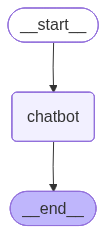

In [6]:
def chatbot(state: MessagesState):
    ai_message = llm.invoke(state["messages"])
    return {"messages": ai_message}


workflow = StateGraph(MessagesState)

workflow.add_node(chatbot)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

checkpointer = MemorySaver()
in_memory_graph = workflow.compile(checkpointer=checkpointer)

display(
    Image(
        in_memory_graph.get_graph().draw_mermaid_png()
    )
)

In [7]:
run_graph(
    query="Hi",
    graph=in_memory_graph, 
    thread_id="1"
)

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='e35518e5-1b14-49af-b4e8-f75bbf3b2c75'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'finish_reason': 'stop', 'logprobs': None}, id='run-20930fb3-6ffc-4d48-9a97-69b8bdb2b264-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [8]:
list(
    in_memory_graph.get_state(
        config={"configurable":{"thread_id": "1"}}
    )
)

[{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='e35518e5-1b14-49af-b4e8-f75bbf3b2c75'),
   AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'finish_reason': 'stop', 'logprobs': None}, id='run-20930fb3-6ffc-4d48-9a97-69b8bdb2b264-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]},
 (),
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1f0d82d6-664e-6b71-8001

**SQLite**

In [9]:
# For production, use something like Postgres
db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

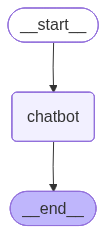

In [10]:
memory = SqliteSaver(conn)
external_memory_graph = workflow.compile(checkpointer=memory)

display(
    Image(
        external_memory_graph.get_graph().draw_mermaid_png()
    )
)

In [11]:
# run_graph(
#     query="What's a memory?",
#     graph=external_memory_graph, 
#     thread_id="2"
# )

In [12]:
list(
    external_memory_graph.get_state(
        config={"configurable":{"thread_id": "2"}}
    )
)

[{'messages': [HumanMessage(content="What's a memory?", additional_kwargs={}, response_metadata={}, id='695bf7f9-c92a-4a1c-8b78-a96dee984579'),
   HumanMessage(content="What's a memory?", additional_kwargs={}, response_metadata={}, id='0877fe20-8566-43c3-b131-746d4a9c64b4'),
   HumanMessage(content="What's a memory?", additional_kwargs={}, response_metadata={}, id='f81c967d-725f-46cb-8c97-00d10083f736'),
   AIMessage(content='A memory is the mental capacity or faculty to store, retain, and recall information and experiences. It involves the processes of encoding (taking in information), storage (maintaining information over time), and retrieval (accessing information when needed). Memories can be of various types, including:\n\n1. **Short-term memory**: Holds a small amount of information for a brief period, typically seconds to minutes.\n2. **Long-term memory**: Stores information for extended periods, potentially for a lifetime. This can be further divided into:\n   - **Explicit memo

**Querying memory**

In [13]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [table_name[0] for table_name in cursor.fetchall()]
tables

['checkpoints', 'writes']

In [14]:
columns_map = []
results = []

for table in tables:
    cursor.execute(f"select * from {table}")
    results.append(cursor.fetchall())
    columns_map.append({table:[desc[0] for desc in cursor.description]})

In [15]:
columns_map

[{'checkpoints': ['thread_id',
   'checkpoint_ns',
   'checkpoint_id',
   'parent_checkpoint_id',
   'type',
   'checkpoint',
   'metadata']},
 {'writes': ['thread_id',
   'checkpoint_ns',
   'checkpoint_id',
   'task_id',
   'idx',
   'channel',
   'type',
   'value']}]

In [16]:
cursor.execute(f"select metadata from checkpoints")
metadata = cursor.fetchall()
metadata

[(b'{"source": "loop", "writes": null, "thread_id": "2", "step": 0, "parents": {}}',),
 (b'{"source": "loop", "writes": null, "thread_id": "2", "step": 2, "parents": {}}',),
 (b'{"source": "loop", "writes": null, "thread_id": "2", "step": 4, "parents": {}}',)]

In [17]:
steps = [json.loads(m[0]) for m in metadata]
steps

[{'source': 'loop',
  'writes': None,
  'thread_id': '2',
  'step': 0,
  'parents': {}},
 {'source': 'loop',
  'writes': None,
  'thread_id': '2',
  'step': 2,
  'parents': {}},
 {'source': 'loop',
  'writes': None,
  'thread_id': '2',
  'step': 4,
  'parents': {}}]